In [12]:
!pip install colorama

Defaulting to user installation because normal site-packages is not writeable


In [13]:
import os
import math
import json
import random as rnd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import pandas as  pd
import torchvision.utils as vision_utils
from PIL import Image
import torchvision
from colorama import Fore, Back, Style
from matplotlib.ticker import NullFormatter
import torchvision.models as model_zoo


DEVICE = torch.device('cuda:3')


In [14]:
import gc
import random
def seed_everything(seed: int):
   # This is a utility function you can use for all your ML applications
   # More generic than you would need for this particular assignment
   gc.collect()
   torch.cuda.empty_cache()
   random.seed(seed)
   np.random.seed(seed)
   os.environ['PYTHONHASHSEED'] = str(seed)
   torch.manual_seed(seed)
   torch.cuda.manual_seed(seed)
   torch.cuda.manual_seed_all(seed)
   torch.backends.cudnn.deterministic = True
   torch.backends.cudnn.benchmark = False

Files already downloaded and verified
Files already downloaded and verified
Train length: 6991
Test length: 1980
Train dataset:


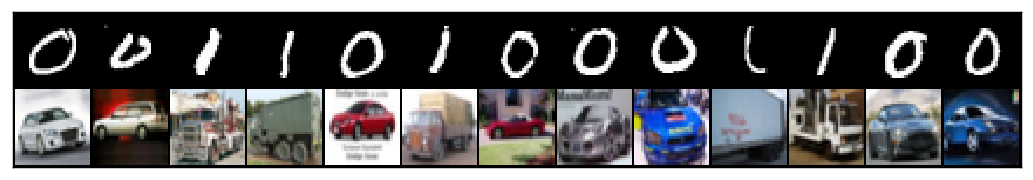

Test dataset:


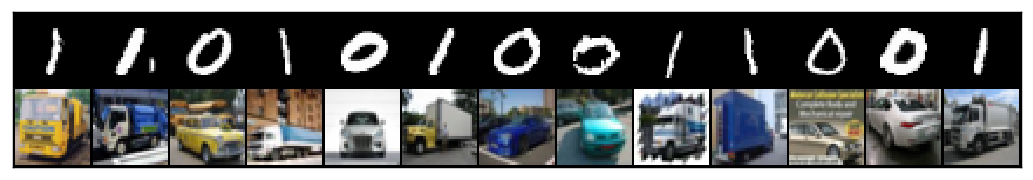

MNIST-blanked test dataset:


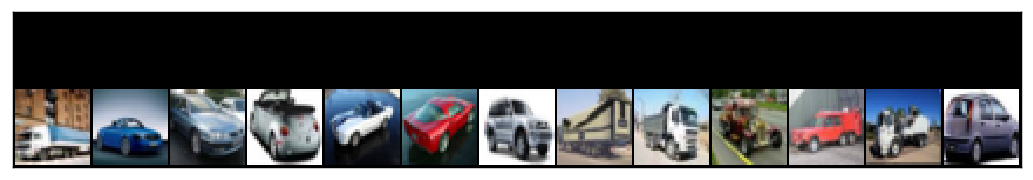

CIFAR10-blanked test dataset:


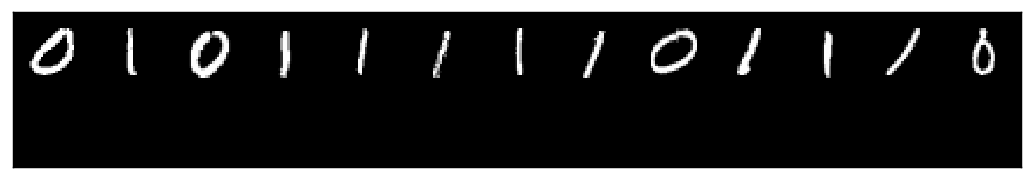

Perturb Dataset:


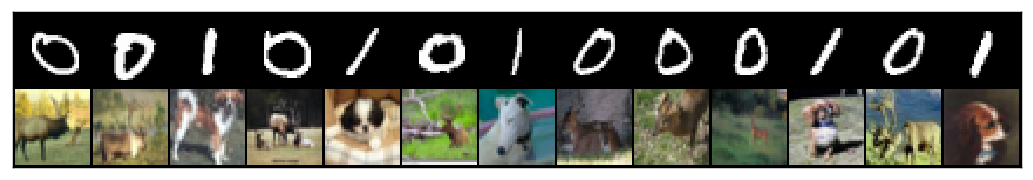

In [16]:
seed_everything(42)

def plot_samples(dataset, nrow=13, figsize=(10,7)):
  try:
    X, Y = dataset.tensors
  except:
    try:
      (X,) = dataset.tensors
    except:
      X = dataset
  fig = plt.figure(figsize=figsize, dpi=130)
  grid_img = vision_utils.make_grid(X[:nrow].cpu(), nrow=nrow, normalize=True, padding=1)
  _ = plt.imshow(grid_img.permute(1, 2, 0), interpolation='nearest')
  _ = plt.tick_params(axis=u'both', which=u'both',length=0)
  ax = plt.gca()
  _ = ax.xaxis.set_major_formatter(NullFormatter())
  _ = ax.yaxis.set_major_formatter(NullFormatter())
  plt.show()


def keep_only_lbls(dataset, lbls):
  lbls = {lbl: i for i, lbl in enumerate(lbls)}
  final_X, final_Y = [], []
  for x, y in dataset:
    if y in lbls:
      final_X.append(x)
      final_Y.append(lbls[y])
  X = torch.stack(final_X)
  Y = torch.tensor(final_Y).float().view(-1,1)
  return X, Y


def format_mnist(imgs):
  imgs = np.stack([np.pad(imgs[i][0], 2, constant_values=0)[None,:] for i in range(len(imgs))])
  imgs = np.repeat(imgs, 3, axis=1)
  return torch.tensor(imgs)


def build_mc_dataset(mnist_data, cifar_data, randomize_m=False, randomize_c=False, blank_mnist = False, blank_cifar = False):
  X_m_train_0, _ = keep_only_lbls(mnist_data, lbls=[0])
  X_m_train_1, _ = keep_only_lbls(mnist_data, lbls=[1])
  X_m_train_0 = format_mnist(X_m_train_0.view(-1, 1, 28, 28))
  X_m_train_1 = format_mnist(X_m_train_1.view(-1, 1, 28, 28))
  X_m_train_0 = X_m_train_0[torch.randperm(len(X_m_train_0))]
  X_m_train_1 = X_m_train_1[torch.randperm(len(X_m_train_1))]

  X_c_train_1, _ = keep_only_lbls(cifar_data, lbls=[1])
  X_c_train_9, _ = keep_only_lbls(cifar_data, lbls=[9])
  X_c_train_1 = X_c_train_1[torch.randperm(len(X_c_train_1))]
  X_c_train_9 = X_c_train_9[torch.randperm(len(X_c_train_9))]

  min_01 = min(len(X_m_train_0), len(X_c_train_1))
  min_19 = min(len(X_m_train_1), len(X_c_train_9))
  X_top = torch.cat((X_m_train_0[:min_01], X_m_train_1[:min_19]),dim=0)
  X_bottom = torch.cat((X_c_train_1[:min_01], X_c_train_9[:min_19]),dim=0)
  if randomize_m:
    shuffle = torch.randperm(len(X_top))
    X_top = X_top[shuffle]
  if randomize_c:
    shuffle = torch.randperm(len(X_bottom))
    X_bottom = X_bottom[shuffle]

  ##### Mask one of the datasets ######
  if blank_mnist:
    X_top = torch.zeros(X_top.size())
  if blank_cifar:
    X_bottom = torch.zeros(X_bottom.size())
  ####################################

  X_train = torch.cat((X_top, X_bottom), dim=2)
  Y_train = torch.cat((torch.zeros((min_01,)), torch.ones((min_19,))))
  shuffle = torch.randperm(len(X_train))
  X_train = X_train[shuffle]
  Y_train = Y_train[shuffle].float().view(-1,1)
  data_train = torch.utils.data.TensorDataset(X_train.to(DEVICE), Y_train.to(DEVICE))
  return data_train

def build_perturb_dataset(mnist_data, cifar_data, randomize_m=False, randomize_c=False, blank_mnist = False, blank_cifar = False):
  X_m_train_0, _ = keep_only_lbls(mnist_data, lbls=[0])
  X_m_train_1, _ = keep_only_lbls(mnist_data, lbls=[1])
  X_m_train_0 = format_mnist(X_m_train_0.view(-1, 1, 28, 28))
  X_m_train_1 = format_mnist(X_m_train_1.view(-1, 1, 28, 28))
  X_m_train_0 = X_m_train_0[torch.randperm(len(X_m_train_0))]
  X_m_train_1 = X_m_train_1[torch.randperm(len(X_m_train_1))]

  X_c_train_1, _ = keep_only_lbls(cifar_data, lbls=[4])
  X_c_train_9, _ = keep_only_lbls(cifar_data, lbls=[5])
  X_c_train_1 = X_c_train_1[torch.randperm(len(X_c_train_1))]
  X_c_train_9 = X_c_train_9[torch.randperm(len(X_c_train_9))]

  min_01 = min(len(X_m_train_0), len(X_c_train_1))
  min_19 = min(len(X_m_train_1), len(X_c_train_9))
  X_top = torch.cat((X_m_train_0[:min_01], X_m_train_1[:min_19]),dim=0)
  X_bottom = torch.cat((X_c_train_1[:min_01], X_c_train_9[:min_19]),dim=0)
  if randomize_m:
    shuffle = torch.randperm(len(X_top))
    X_top = X_top[shuffle]
  if randomize_c:
    shuffle = torch.randperm(len(X_bottom))
    X_bottom = X_bottom[shuffle]

  ##### Mask one of the datasets ######
  if blank_mnist:
    X_top = torch.zeros(X_top.size())
  if blank_cifar:
    X_bottom = torch.zeros(X_bottom.size())
  ####################################

  X_train = torch.cat((X_top, X_bottom), dim=2)
  Y_train = torch.cat((torch.zeros((min_01,)), torch.ones((min_19,))))
  shuffle = torch.randperm(len(X_train))
  X_train = X_train[shuffle]
  Y_train = Y_train[shuffle].float().view(-1,1)
  data_train = torch.utils.data.TensorDataset(X_train.to(DEVICE), Y_train.to(DEVICE))
  return data_train


transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

mnist_train = torchvision.datasets.MNIST('./data/mnist/', train=True, download=True, transform=transform)
cifar_train = torchvision.datasets.CIFAR10('./data/cifar10/', train=True, download=True, transform=transform)
mnist_perturb_base, mnist_train, mnist_valid = random_split(mnist_train, [10000, 45000, 5000], generator=torch.Generator().manual_seed(42))
cifar_perturb_base, cifar_train, cifar_valid = random_split(cifar_train, [10000, 35000, 5000], generator=torch.Generator().manual_seed(42))

mnist_test = torchvision.datasets.MNIST('./data/mnist/', train=False, download=True, transform=transform)
cifar_test = torchvision.datasets.CIFAR10('./data/cifar10/', train=False, download=True, transform=transform)


# Training / valid / test datasets
data_train = build_mc_dataset(mnist_train, cifar_train)
data_valid = build_mc_dataset(mnist_valid, cifar_valid)
data_test = build_mc_dataset(mnist_test, cifar_test)

train_dl = torch.utils.data.DataLoader(data_train, batch_size=256, shuffle=False)
valid_dl = torch.utils.data.DataLoader(data_valid, batch_size=1024, shuffle=False)
test_dl = torch.utils.data.DataLoader(data_test, batch_size=1024, shuffle=False)


# # MNIST masked dataset
data_test_rm = build_mc_dataset(mnist_test, cifar_test,blank_mnist=True, blank_cifar=False)
data_valid_rm = build_mc_dataset(mnist_valid, cifar_valid,blank_mnist=True, blank_cifar=False)

test_rm_dl = torch.utils.data.DataLoader(data_test_rm, batch_size=1024, shuffle=False)
valid_rm_dl = torch.utils.data.DataLoader(data_valid_rm, batch_size=1024, shuffle=False)

# # CIFAR masked dataset
data_test_rc = build_mc_dataset(mnist_test, cifar_test, blank_mnist=False, blank_cifar=True)
data_valid_rc = build_mc_dataset(mnist_valid, cifar_valid, blank_mnist=False, blank_cifar=True)

test_rc_dl = torch.utils.data.DataLoader(data_test_rc, batch_size=1024, shuffle=False)
valid_rc_dl = torch.utils.data.DataLoader(data_valid_rc, batch_size=1024, shuffle=False)

# Perturb DL
perturb_data = build_perturb_dataset(mnist_train, cifar_train)
perturb_dl = torch.utils.data.DataLoader(perturb_data, batch_size=1024, shuffle=False)

print(f"Train length: {len(train_dl.dataset)}")
print(f"Test length: {len(test_dl.dataset)}")

print("Train dataset:")
plot_samples(data_train)

print("Test dataset:")
plot_samples(data_test)

print("MNIST-blanked test dataset:")
plot_samples(data_test_rm)

print("CIFAR10-blanked test dataset:")
plot_samples(data_test_rc)

print("Perturb Dataset:")
plot_samples(perturb_data)

In [17]:
@torch.no_grad()
def get_acc(model, dl):
  with torch.no_grad():
    model.eval()
    acc = []
    for X, y in dl:
      acc.append((torch.sigmoid(model(X)) > 0.5) == y)
    acc = torch.cat(acc)
    acc = torch.sum(acc)/len(acc)
    model.train()
  return acc.item()


@torch.no_grad()
def get_ens_acc(ensemble, dl):
  for model in ensemble:
    model.eval()
  acc = []
  for X, y in dl:
    probs = [torch.sigmoid(model(X)) for model in ensemble]
    probs = torch.stack(probs).mean(dim=0)
    acc.append((probs > 0.5) == y)
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  for model in ensemble:
    model.train()
  return acc.item()


def dl_to_sampler(dl):
  dl_iter = iter(dl)
  def sample():
    nonlocal dl_iter
    try:
      return next(dl_iter)
    except StopIteration:
      dl_iter = iter(dl)
      return next(dl_iter)
  return sample


def print_stats(stats):

  fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(16,3), dpi=110)
  ax1.grid()
  ax2.grid()
  ax3.grid()
  ax4.grid()
  ax5.grid()

  ax1.set_title("ERM loss")
  ax2.set_title("Adv Loss")
  ax3.set_title("Acc")
  ax4.set_title("Masked MNIST Acc")
  ax5.set_title("Masked CIFAR Acc")

  ax1.set_xlabel("iterations")
  ax2.set_xlabel("iterations")
  ax3.set_xlabel("iterations")
  ax4.set_xlabel("iterations")
  ax5.set_xlabel("iterations")

  for m_id, m_stats in stats.items():
    if m_id[0] != 'm':
      continue
    itrs = [x[0] for x in m_stats['loss']]
    ax1.plot(itrs, [x[1] for x in m_stats['loss']], label=m_id)
    ax2.plot(itrs, [x[1] for x in m_stats['adv-loss']], label=m_id)
    ax3.plot(itrs, [x[1] for x in m_stats['acc']], label=m_id)
    ax4.plot(itrs, [x[1] for x in m_stats['rm-acc']], label=m_id)
    ax5.plot(itrs, [x[1] for x in m_stats['rc-acc']], label=m_id)

  ax3.set_ylim(0.45, 1.05)
  ax4.set_ylim(0.45, 1.05)
  ax5.set_ylim(0.45, 1.05)

In [18]:
class LeNet(nn.Module):

    def __init__(self, num_classes=10, dropout_p=0.0) -> None:
        super(LeNet, self).__init__()
        self.droput_p = dropout_p
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 56, kernel_size=5)
        self.fc1 = nn.Linear(2016, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.avgpool_2 = nn.AvgPool2d(kernel_size=2)
        self.avgpool_3 = nn.AvgPool2d(kernel_size=3)

    def forward(self, x: torch.Tensor, dropout=True, show_img=False) -> torch.Tensor:
        x = self.relu(self.conv1(x))
        x = F.dropout(x, p=self.droput_p, training=dropout)
        if(show_img):
          fig, axes = plt.subplots(2, 16, figsize=(16,4))
          axes = axes.flatten()
          for i in range(32):
            axes[i].matshow(x[0, i, :, :].detach().cpu().numpy())
            axes[i].axis('off')
          plt.suptitle("Output after first convolution layer on a domino image (MNIST + CIFAR-10)")
          plt.show()
        x = self.avgpool_2(x)
        x = self.relu(self.conv2(x))
        x = F.dropout(x, p=self.droput_p, training=dropout)
        x = self.avgpool_3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = F.dropout(x, p=self.droput_p, training=dropout)
        x = self.fc2(x)
        x = self.relu(x)
        x = F.dropout(x, p=self.droput_p, training=dropout)
        x = self.fc3(x)
        return x


def set_train_mode(models):
  for m in models:
    m.train()


def set_eval_mode(models):
  for m in models:
    m.eval()

In [19]:
def m_f():
  m = model_zoo.resnet18(pretrained=True)
  d = m.fc.in_features
  m.fc = nn.Linear(d, 2)
  return m

seed_everything(42)
for itr, (x, y) in enumerate(train_dl):
  visual_image = x
  break

def sequential_train(num_models, train_dl, valid_dl, valid_rm_dl, valid_rc_dl, test_dl, test_rm_dl,
                     test_rc_dl, perturb_dl=None, alpha=10, max_epoch=100, opt='SGD',
                     use_diversity_reg=True, reg_model_weights=None, lr_max=0.2, weight_decay=1e-5, use_scheduler=True):
  seed_everything(42)
  models = [LeNet(num_classes=1).to(DEVICE) for _ in range(num_models)]
  opts = [None for _ in range(num_models)]
  schedulers = [None for _ in range(num_models)]
  print(models[0])
  # models = [LeNet(num_classes=1).to(DEVICE) for _ in range(num_models)]
  set_train_mode(models)

  stats = {f"m{i+1}": {"acc": [], "rm-acc": [], "rc-acc": [], "loss": [], "adv-loss": []} for i in range(len(models))}

  if reg_model_weights is None:
    reg_model_weights = [1.0 for _ in range(num_models)]

  for m_idx, m in enumerate(models):
    set_eval_mode(models)
    m.train()
    if opt == 'SGD':
      opts[m_idx] = torch.optim.SGD(m.parameters(), lr=lr_max, momentum=0.9, weight_decay=weight_decay)
    else:
      opts[m_idx] = torch.optim.AdamW(m.parameters(), lr=lr_max, weight_decay=weight_decay)
    if use_scheduler:
      schedulers[m_idx] = torch.optim.lr_scheduler.CyclicLR(opts[m_idx], 0, lr_max, step_size_up=(len(train_dl)*max_epoch)//2,
                                                    mode='triangular', cycle_momentum=False)
    else:
      schedulers[m_idx] = None
    
    perturb_sampler = dl_to_sampler(perturb_dl)

    for epoch in range(max_epoch):
      for itr, (x, y) in enumerate(train_dl):
        x_tilde = perturb_sampler()[0]
        # x_tilde = x
        erm_loss = F.binary_cross_entropy_with_logits(m(x), y)

        if use_diversity_reg and m_idx != 0:
          adv_loss = []
          with torch.no_grad():
            set_eval_mode(models)
            ps = [torch.sigmoid(m_(x_tilde)) for m_ in models[:m_idx]]
            set_train_mode(models)
          psm = torch.sigmoid(m(x_tilde))
          for i in range(len(ps)):
            al = - ((1.-ps[i]) * psm + ps[i] * (1.-psm) + 1e-7).log().mean()
            adv_loss.append(al*reg_model_weights[i])
        else:
          adv_loss = [torch.tensor([0]).to(DEVICE)]

        adv_loss = sum(adv_loss)/sum(reg_model_weights[:len(adv_loss)])
        loss = erm_loss + alpha * adv_loss

        opts[m_idx].zero_grad()
        loss.backward()
        opts[m_idx].step()
        if schedulers[m_idx] is not None: schedulers[m_idx].step()

        if (itr + epoch * len(train_dl)) % 200 == 0:
          set_eval_mode(models)
          itr_ = itr + epoch * len(train_dl)
          print_str = f"[m{m_idx+1}] {epoch}/{itr_} [train] loss: {erm_loss.item():.2f} adv-loss: {adv_loss.item():.2f} "
          if itr_ != 0 and schedulers[m_idx] is not None:
            print_str += f"[lr] {schedulers[m_idx].get_last_lr()[0]:.5f} "
          stats[f"m{m_idx+1}"]["loss"].append((itr_, erm_loss.item()))
          stats[f"m{m_idx+1}"]["adv-loss"].append((itr_, adv_loss.item()))
          acc = get_acc(m, valid_dl)
          acc_rm = get_acc(m, valid_rm_dl)
          acc_rc = get_acc(m, valid_rc_dl)
          stats[f"m{m_idx+1}"]["acc"].append((itr_, acc))
          stats[f"m{m_idx+1}"]["rm-acc"].append((itr_, acc_rm))
          stats[f"m{m_idx+1}"]["rc-acc"].append((itr_, acc_rc))
          print_str += f" acc: {acc:.2f}, {Fore.BLUE} r0/1-acc: {acc_rm:.2f} {Style.RESET_ALL}"
          set_train_mode(models)
          print(print_str)

        itr += 1

    test_acc = get_acc(m, test_dl)
    test_rm_acc = get_acc(m, test_rm_dl)
    test_rc_acc = get_acc(m, test_rc_dl)
    ensemble_acc = get_ens_acc(models, test_rm_dl)
    stats[f"m{m_idx+1}"]["test-acc"] = test_acc
    stats[f"m{m_idx+1}"]["test-rm-acc"] = test_rm_acc
    stats[f"m{m_idx+1}"]["test-rc-acc"] = test_rc_acc
    stats[f"m{m_idx+1}"]["ens-test-rm-acc"] = ensemble_acc
    print(f"[m{m_idx+1}] [test] acc: {test_acc:.3f}, r-acc: {test_rm_acc:.3f}, r-acc-ens: {ensemble_acc:.3f}")


    m.eval()
    m(visual_image, show_img=True)


  return stats


def sequential_train_without_dbat(num_models, train_dl, valid_dl, valid_rm_dl, valid_rc_dl, test_dl, test_rm_dl,
                     test_rc_dl, perturb_dl=None, alpha=10, max_epoch=100, opt='SGD',
                     use_diversity_reg=True, reg_model_weights=None, lr_max=0.2, weight_decay=1e-5, use_scheduler=True):
    seed_everything(42)
    models = [LeNet(num_classes=1).to(DEVICE) for _ in range(num_models)]
    opts = [None for _ in range(num_models)]
    schedulers = [None for _ in range(num_models)]
    # models = [LeNet(num_classes=1).to(DEVICE) for _ in range(num_models)]
    set_eval_mode(models)

    stats = {f"m{i+1}": {"acc": [], "rm-acc": [], "rc-acc": [], "loss": [], "adv-loss": []} for i in range(len(models))}

    if reg_model_weights is None:
      reg_model_weights = [1.0 for _ in range(num_models)]


    for m_idx, m in enumerate(models):
      set_eval_mode(models)
      m.train()
      if opt == 'SGD':
        opts[m_idx] = torch.optim.SGD(m.parameters(), lr=lr_max, momentum=0.9, weight_decay=weight_decay)
      else:
        opts[m_idx] = torch.optim.AdamW(m.parameters(), lr=lr_max, weight_decay=weight_decay)
      if use_scheduler:
        schedulers[m_idx] = torch.optim.lr_scheduler.CyclicLR(opts[m_idx], 0, lr_max, step_size_up=(len(train_dl)*max_epoch)//2,
                                                      mode='triangular', cycle_momentum=False)
      else:
        schedulers[m_idx] = None
      # perturb_sampler = dl_to_sampler(perturb_dl)

      for epoch in range(max_epoch):
        for itr, (x, y) in enumerate(train_dl):
          m.train()
          # (x_tilde,) = perturb_sampler()
          x_tilde = x
          erm_loss = F.binary_cross_entropy_with_logits(m(x), y)

          if use_diversity_reg and m_idx != 0:
            adv_loss = []
            with torch.no_grad():
              set_eval_mode(models)
              ps = [torch.sigmoid(m_(x_tilde)) for m_ in models[:m_idx]]
              set_train_mode(models)
            psm = torch.sigmoid(m(x_tilde))
            for i in range(len(ps)):
              al = - ((1.-ps[i]) * psm + ps[i] * (1.-psm) + 1e-7).log().mean()
              adv_loss.append(al*reg_model_weights[i])
          else:
            adv_loss = [torch.tensor([0]).to(DEVICE)]

          adv_loss = sum(adv_loss)/sum(reg_model_weights[:len(adv_loss)])
          # if(itr==0):
          #   print(f"T: {itr} {epoch} {erm_loss.item()} {schedulers[m_idx].get_last_lr()[0]:.5f}")
          loss = erm_loss

          opts[m_idx].zero_grad()
          loss.backward()
          opts[m_idx].step()
          if schedulers[m_idx] is not None: schedulers[m_idx].step()

          if (itr + epoch * len(train_dl)) % 200 == 0:
            set_eval_mode(models)
            itr_ = itr + epoch * len(train_dl)
            print_str = f"[m{m_idx+1}] {epoch}/{itr_} [train] loss: {erm_loss.item():.2f} adv-loss: {adv_loss.item():.2f} "
            if itr_ != 0 and schedulers[m_idx] is not None:
              print_str += f"[lr] {schedulers[m_idx].get_last_lr()[0]:.5f} "
            stats[f"m{m_idx+1}"]["loss"].append((itr_, erm_loss.item()))
            stats[f"m{m_idx+1}"]["adv-loss"].append((itr_, adv_loss.item()))
            acc = get_acc(m, valid_dl)
            acc_rm = get_acc(m, valid_rm_dl)
            acc_rc = get_acc(m, valid_rc_dl)
            stats[f"m{m_idx+1}"]["acc"].append((itr_, acc))
            stats[f"m{m_idx+1}"]["rm-acc"].append((itr_, acc_rm))
            stats[f"m{m_idx+1}"]["rc-acc"].append((itr_, acc_rc))
            print_str += f" acc: {acc:.2f}, {Fore.BLUE} r0/1-acc: {acc_rm:.2f} {Style.RESET_ALL}"
            set_train_mode(models)
            print(print_str)

          itr += 1

      test_acc = get_acc(m, test_dl)
      test_rm_acc = get_acc(m, test_rm_dl)
      test_rc_acc = get_acc(m, test_rc_dl)
      ensemble_acc = get_ens_acc(models, test_rm_dl)
      stats[f"m{m_idx+1}"]["test-acc"] = test_acc
      stats[f"m{m_idx+1}"]["test-rm-acc"] = test_rm_acc
      stats[f"m{m_idx+1}"]["test-rc-acc"] = test_rc_acc
      stats[f"m{m_idx+1}"]["ens-test-rm-acc"] = ensemble_acc
      print(f"[m{m_idx+1}] [test] acc: {test_acc:.3f}, r-acc: {test_rm_acc:.3f}, r-acc-ens: {ensemble_acc:.3f}")

      m.eval()
      m(visual_image, show_img=True)

    return stats

LeNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 56, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2016, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
  (avgpool_2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (avgpool_3): AvgPool2d(kernel_size=3, stride=3, padding=0)
)
[m1] 0/0 [train] loss: 0.69 adv-loss: 0.00  acc: 0.51,  r0/1-acc: 0.51 
[m1] 7/200 [train] loss: 0.68 adv-loss: 0.00 [lr] 0.00239  acc: 0.96,  r0/1-acc: 0.51 
[m1] 14/400 [train] loss: 0.03 adv-loss: 0.00 [lr] 0.00477  acc: 0.99,  r0/1-acc: 0.51 
[m1] 21/600 [train] loss: 0.01 adv-loss: 0.00 [lr] 0.00715  acc: 1.00,  r0/1-acc: 0.51 
[m1] 28/800 [train] loss: 0.01 adv-loss: 0.00 [lr] 0.00954  acc: 1.00,  r0/1-acc: 0.51 
[m1] 35/1000 [train] loss: 0.01 adv-loss: 0.00 [lr] 0.00808  acc: 1.00,  r0/1-acc: 0.51 
[m1] 42/1200 [trai

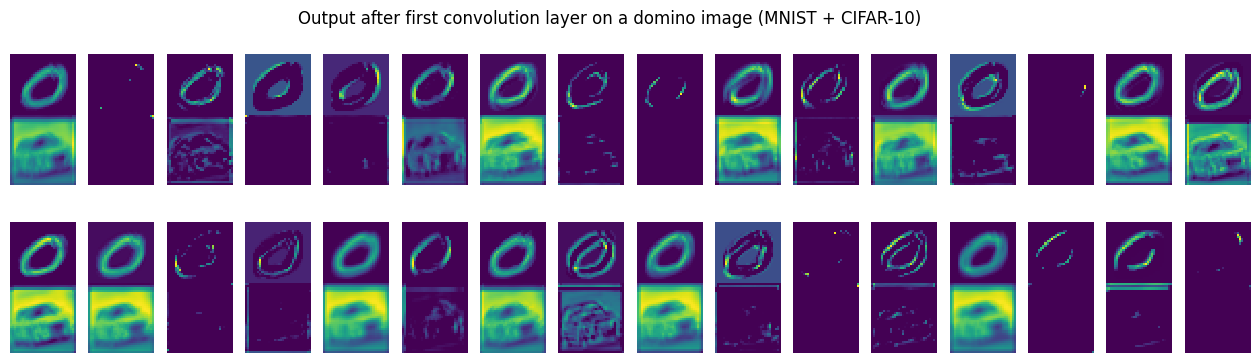

[m2] 0/0 [train] loss: 0.70 adv-loss: 0.69  acc: 0.51,  r0/1-acc: 0.51 
[m2] 7/200 [train] loss: 0.69 adv-loss: 0.70 [lr] 0.00239  acc: 0.52,  r0/1-acc: 0.51 
[m2] 14/400 [train] loss: 0.64 adv-loss: 0.74 [lr] 0.00477  acc: 0.96,  r0/1-acc: 0.55 
[m2] 21/600 [train] loss: 0.26 adv-loss: 0.86 [lr] 0.00715  acc: 0.89,  r0/1-acc: 0.60 
[m2] 28/800 [train] loss: 0.29 adv-loss: 0.35 [lr] 0.00954  acc: 0.95,  r0/1-acc: 0.57 
[m2] 35/1000 [train] loss: 0.23 adv-loss: 0.20 [lr] 0.00808  acc: 0.96,  r0/1-acc: 0.54 
[m2] 42/1200 [train] loss: 0.14 adv-loss: 0.18 [lr] 0.00570  acc: 0.94,  r0/1-acc: 0.54 
[m2] 50/1400 [train] loss: 0.06 adv-loss: 0.23 [lr] 0.00332  acc: 0.93,  r0/1-acc: 0.57 
[m2] 57/1600 [train] loss: 0.09 adv-loss: 0.19 [lr] 0.00094  acc: 0.94,  r0/1-acc: 0.56 
[m2] [test] acc: 0.962, r-acc: 0.540, r-acc-ens: 0.509


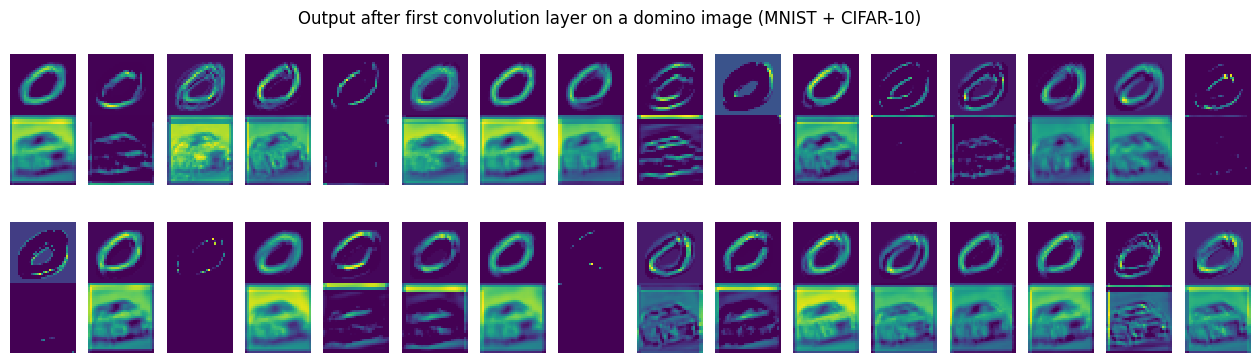

In [25]:
all_stats = []
stats = sequential_train(2, train_dl, valid_dl, valid_rm_dl, valid_rc_dl, test_dl, test_rm_dl, test_rc_dl,
                          alpha=0.5, max_epoch=60, lr_max=0.01, perturb_dl=perturb_dl)
all_stats.append(stats)


[m1] 0/0 [train] loss: 0.69 adv-loss: 0.00  acc: 0.51,  r0/1-acc: 0.51 
[m1] 7/200 [train] loss: 0.68 adv-loss: 0.00 [lr] 0.00239  acc: 0.96,  r0/1-acc: 0.51 
[m1] 14/400 [train] loss: 0.03 adv-loss: 0.00 [lr] 0.00477  acc: 0.99,  r0/1-acc: 0.51 
[m1] 21/600 [train] loss: 0.01 adv-loss: 0.00 [lr] 0.00715  acc: 1.00,  r0/1-acc: 0.51 
[m1] 28/800 [train] loss: 0.01 adv-loss: 0.00 [lr] 0.00954  acc: 1.00,  r0/1-acc: 0.51 
[m1] 35/1000 [train] loss: 0.01 adv-loss: 0.00 [lr] 0.00808  acc: 1.00,  r0/1-acc: 0.51 
[m1] 42/1200 [train] loss: 0.01 adv-loss: 0.00 [lr] 0.00570  acc: 1.00,  r0/1-acc: 0.51 
[m1] 50/1400 [train] loss: 0.00 adv-loss: 0.00 [lr] 0.00332  acc: 1.00,  r0/1-acc: 0.51 
[m1] 57/1600 [train] loss: 0.00 adv-loss: 0.00 [lr] 0.00094  acc: 1.00,  r0/1-acc: 0.51 
[m1] [test] acc: 0.999, r-acc: 0.505, r-acc-ens: 0.505


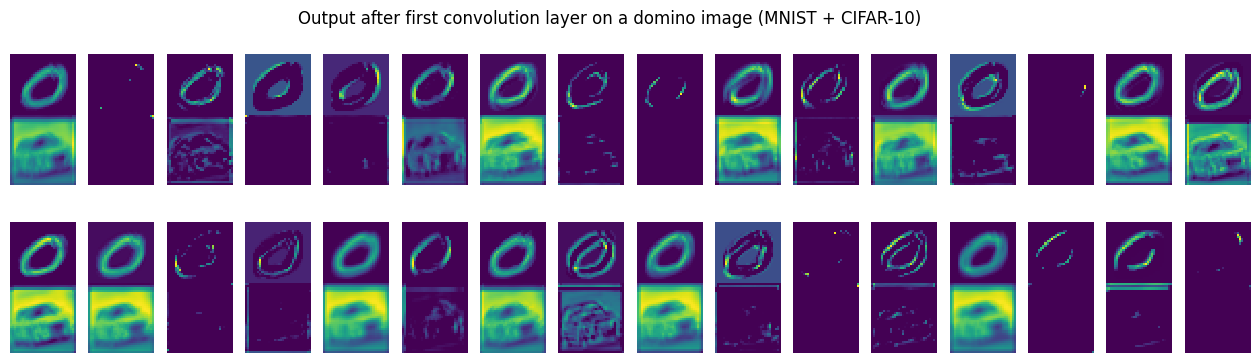

[m2] 0/0 [train] loss: 0.70 adv-loss: 0.69  acc: 0.51,  r0/1-acc: 0.51 
[m2] 7/200 [train] loss: 0.69 adv-loss: 0.70 [lr] 0.00239  acc: 0.80,  r0/1-acc: 0.51 
[m2] 14/400 [train] loss: 0.03 adv-loss: 7.64 [lr] 0.00477  acc: 0.99,  r0/1-acc: 0.51 
[m2] 21/600 [train] loss: 0.01 adv-loss: 9.24 [lr] 0.00715  acc: 1.00,  r0/1-acc: 0.51 
[m2] 28/800 [train] loss: 0.02 adv-loss: 9.77 [lr] 0.00954  acc: 1.00,  r0/1-acc: 0.51 
[m2] 35/1000 [train] loss: 0.02 adv-loss: 10.48 [lr] 0.00808  acc: 1.00,  r0/1-acc: 0.51 
[m2] 42/1200 [train] loss: 0.01 adv-loss: 10.18 [lr] 0.00570  acc: 1.00,  r0/1-acc: 0.51 
[m2] 50/1400 [train] loss: 0.00 adv-loss: 10.88 [lr] 0.00332  acc: 1.00,  r0/1-acc: 0.51 
[m2] 57/1600 [train] loss: 0.00 adv-loss: 10.65 [lr] 0.00094  acc: 1.00,  r0/1-acc: 0.51 
[m2] [test] acc: 0.999, r-acc: 0.505, r-acc-ens: 0.505


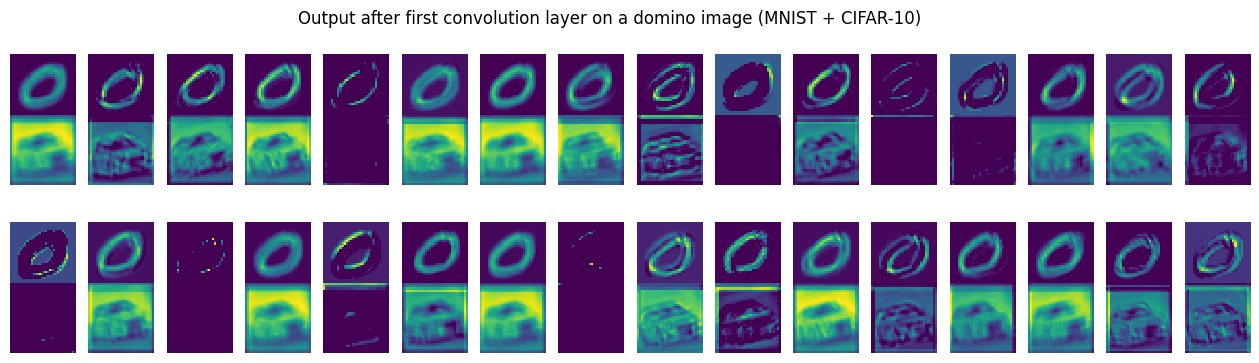

In [24]:
all_stats = []
stats = sequential_train_without_dbat(2, train_dl, valid_dl, valid_rm_dl, valid_rc_dl, test_dl, test_rm_dl, test_rc_dl,
                          alpha=0, max_epoch=60, lr_max=0.01)
all_stats.append(stats)